## This notebook implements the LSTM-CNN model with attention mechanism with and without gradient compression.


####  `load_and_preprocess_data`  function reads the dataset from a specified CSV file and cleans it by removing any rows with missing values. It's the first step in preparing the data for analysis, ensuring that the dataset is complete and ready for further processing.


#### `prepare_features_and_labels`  function selects the relevant features (input variables) and the target label (output variable) from the dataset. It transforms the data into a format that can be fed into a machine learning model, separating the input features (`X`) from the target labels (`y`).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Multiply
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import tensorflow as tf
import time

# Data Preprocessing Functions
def load_and_preprocess_data(file_path):
    """_summary_

    Args:
        file_path (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = pd.read_csv(file_path)
    data = data.dropna()  
    return data

def prepare_features_and_labels(data):
    """_summary_

    Args:
        data (_type_): _description_

    Returns:
        _type_: _description_
    """
    features = ['TP2', 'DV_pressure', 'Oil_temperature', 'Motor_current', 'DV_eletric', 'Towers', 'LPS', 'Oil_level', 'Caudal_impulses']
    target = 'class'
    X = data[features].values
    y = data[target].values
    return X, y


#### This funtion balances classes as the data is very imbalanced with less than 10% anomaly classes (1)


In [ ]:

def balance_and_sample(X, y, sample_fraction=0.4):
    """_summary_

    Args:
        X (_type_): _description_
        y (_type_): _description_
        sample_fraction (float, optional): _description_. Defaults to 0.4.

    Returns:
        _type_: _description_
    """
    X, y = shuffle(X, y, random_state=42)
    sample_size = int(sample_fraction * len(X))
    X_sample, y_sample = X[:sample_size], y[:sample_size]
    
    classes = np.unique(y_sample)
    max_samples = max([np.sum(y_sample == cls) for cls in classes])
    
    X_balanced = []
    y_balanced = []
    
    for cls in classes:
        X_cls = X_sample[y_sample == cls]
        y_cls = y_sample[y_sample == cls]
        
        X_balanced.append(X_cls[:max_samples])
        y_balanced.append(y_cls[:max_samples])
    
    X_balanced = np.vstack(X_balanced)
    y_balanced = np.hstack(y_balanced)
    
    return X_balanced, y_balanced

In [ ]:
def preprocess_data(data):
    """_summary_

    Args:
        data (_type_): _description_

    Raises:
        ValueError: _description_
        ValueError: _description_
        ValueError: _description_

    Returns:
        _type_: _description_
    """
    if 'timestamp' not in data.columns or 'class' not in data.columns:
        raise ValueError("Data must contain 'timestamp' and 'class' columns.")
    
    data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
    data = data.dropna(subset=['timestamp'])
    data['month'] = data['timestamp'].dt.to_period('M')
    months = data['month'].astype(str).unique()
    
    if len(months) < 4:
        raise ValueError("Not enough distinct months to split into global and client data.")
    
    months.sort()
    first_two_months = months[:2]
    last_two_months = months[-2:]
    
    global_data = data[data['month'].astype(str).isin(first_two_months)]
    client1_data = data[data['month'].astype(str) == last_two_months[0]]
    client2_data = data[data['month'].astype(str) == last_two_months[1]]
    
    if global_data.empty or client1_data.empty or client2_data.empty:
        raise ValueError("One or more of the filtered datasets are empty.")
    
    return global_data, client1_data, client2_data

#### Compressing gradients based on threshold (refer to the markdown with interpretation from the paper).

The gradient compression method emphasizes **sparsification**, where only the top 0.1% of gradients with the largest absolute values are transmitted, effectively zeroing out 99.9% of the gradients. This approach significantly reduces the amount of data exchanged between edge devices and the central server, enhancing communication efficiency in distributed machine learning systems. By focusing on the most significant gradient updates, this method ensures that essential information is preserved while minimizing the data overhead, making it especially effective for edge computing environments with limited bandwidth.


In [3]:
def compress_gradients(gradients):
    """Applies gradient sparsification by keeping only the top 0.1% of the most significant gradients."""
    compressed_gradients = []
    for grad in gradients:
        # Flatten the gradient array to apply sparsification
        flat_grad = tf.reshape(grad, [-1])
        
        # Calculate the threshold for top 0.1% gradients
        # `tf.abs(flat_grad)` gives absolute values of gradients, then we use `tf.nn.top_k` to find the threshold
        k = int(0.001 * tf.size(flat_grad).numpy())  # 0.1% of the total number of gradients
        threshold_value = tf.nn.top_k(tf.abs(flat_grad), k=k).values[-1]  # Get the smallest value in the top 0.1%
        
        # Sparsify the gradients: zero out values below the threshold
        sparsified_grad = tf.where(tf.abs(flat_grad) >= threshold_value, flat_grad, tf.zeros_like(flat_grad))
        
        # Reshape back to the original gradient shape
        sparsified_grad = tf.reshape(sparsified_grad, tf.shape(grad))
        
        compressed_gradients.append(sparsified_grad)
    
    return compressed_gradients


`create_cnn_lstm_attention_model`

This function defines and returns a neural network model that combines Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM) layers, with an added attention mechanism.

- **CNN Layers**: The initial layers apply convolutional operations to extract spatial features from the input data. This is followed by a pooling layer to reduce the spatial dimensions and a dropout layer to prevent overfitting.

- **LSTM Layers**: The next layer processes the temporal dependencies in the data. By setting `return_sequences=True`, it returns the full sequence of outputs for further processing.

- **Attention Mechanism**: An attention layer is applied to focus on the most relevant parts of the sequence data, enhancing the model's ability to capture important temporal patterns.

- **Final Layers**: The output of the attention mechanism is passed through another LSTM layer, followed by a dense layer for further processing. The final output layer uses a sigmoid activation function to predict the probability of the target class.

The model is compiled using the Adam optimizer and binary cross-entropy loss, making it suitable for binary classification tasks.



In [ ]:
# Create Models
def create_cnn_lstm_attention_model(input_shape):
    """Create a CNN-LSTM model with attention mechanism."""
    inputs = Input(shape=input_shape)
    
    # CNN layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Dropout(0.2)(x)
    
    # LSTM layers
    x = LSTM(50, return_sequences=True)(x)
    
    # Attention Mechanism
    attention_probs = Dense(x.shape[-1], activation='softmax')(x)
    attention_mul = Multiply()([x, attention_probs])
    
    x = LSTM(50)(attention_mul)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

This function simulates a federated learning process where a global model is trained using data from multiple clients. The model is first trained on a global dataset, and then fine-tuned using smaller datasets from individual clients. The function also considers the use of gradient compression, which helps reduce the amount of data that needs to be communicated during training. After fine-tuning, the model's performance is evaluated on the global data to determine its accuracy and other metrics. The results include various performance metrics, such as training time, fine-tuning time, and overall accuracy.


In [ ]:
# Federated Learning with and without Gradient Compression
def federated_learning(global_data, client1_data, client2_data, use_gradient_compression):

    """_summary_

    Returns:
        _type_: _description_
    """
    results = {}
    
    # Prepare global data
    print("Preparing global data...")
    X_global, y_global = prepare_features_and_labels(global_data)
    X_global, y_global = balance_and_sample(X_global, y_global, sample_fraction=0.4)
    X_global = X_global[:, np.newaxis, :]
    
    # Prepare client data
    print("Preparing client data...")
    X_client1, y_client1 = prepare_features_and_labels(client1_data)
    X_client2, y_client2 = prepare_features_and_labels(client2_data)
    X_client1, y_client1 = balance_and_sample(X_client1, y_client1, sample_fraction=0.4)
    X_client2, y_client2 = balance_and_sample(X_client2, y_client2, sample_fraction=0.4)
    X_client1 = X_client1[:, np.newaxis, :]
    X_client2 = X_client2[:, np.newaxis, :]
    
    # Create and train global model
    print("Creating and training global model...")
    model = create_cnn_lstm_attention_model(input_shape=(X_global.shape[1], X_global.shape[2]))
    _, train_time_global = measure_communication_time(model.fit, X_global, y_global, epochs=10, batch_size=32, verbose=2)
    print(f"Time to train global model: {train_time_global:.2f} seconds.")
    
    # Fine-tune model on client data
    client_data = [
        (X_client1, y_client1, "Client 1"),
        (X_client2, y_client2, "Client 2")
    ]
    
    print("Fine-tuning model on client data...")
    for X_client, y_client, client_name in tqdm(client_data, desc="Clients", unit="client"):
        print(f"Fine-tuning on {client_name}...")
        
        def train_func():
            model.fit(X_client, y_client, epochs=5, batch_size=32, verbose=2)
        
        _, update_time = measure_communication_time(train_func)
        print(f"Time to fine-tune on {client_name}: {update_time:.2f} seconds.")
        
        # Compress gradients and simulate communication if required
        if use_gradient_compression:
            # Assuming a function to apply gradient compression to model weights/gradients
            compressed_gradients = compress_gradients(model.get_weights())
            # Apply the compressed gradients to the model (This part is a simulation)
            model.set_weights([tf.convert_to_tensor(g) for g in compressed_gradients])
    
    # Evaluate the updated global model
    print("Evaluating the updated global model...")
    start_time = time.time()
    y_global_pred = (model.predict(X_global) > 0.5).astype(int)
    report = classification_report(y_global, y_global_pred, output_dict=True)
    accuracy = accuracy_score(y_global, y_global_pred)
    elapsed_time = time.time() - start_time
    
    print("Model Classification Report:")
    print(report)
    print("Model Accuracy Score:", accuracy)
    print(f"Model evaluation completed in {elapsed_time:.2f} seconds.")
    
    results['accuracy'] = accuracy
    results['classification_report'] = report
    results['training_time'] = train_time_global
    results['fine_tuning_time'] = update_time
    results['evaluation_time'] = elapsed_time
    
    return results

In [ ]:
# Measure communication time
def measure_communication_time(func, *args, **kwargs):
    """Measure the time taken for a function to execute."""
    start_time = time.time()
    result = func(*args, **kwargs)
    elapsed_time = time.time() - start_time
    return result, elapsed_time

In [4]:
# Main Code
file_path = 'Metro-Both-Classes.csv'
data = load_and_preprocess_data(file_path)
global_data, client1_data, client2_data = preprocess_data(data)

# Perform federated learning with and without gradient compression
results_without_compression = federated_learning(global_data, client1_data, client2_data, use_gradient_compression=False)
results_with_compression = federated_learning(global_data, client1_data, client2_data, use_gradient_compression=True)

Preparing global data...
Preparing client data...
Creating and training global model...
Epoch 1/10
5145/5145 - 23s - 4ms/step - accuracy: 0.9733 - loss: 0.0650
Epoch 2/10
5145/5145 - 18s - 3ms/step - accuracy: 0.9745 - loss: 0.0458
Epoch 3/10
5145/5145 - 18s - 4ms/step - accuracy: 0.9841 - loss: 0.0356
Epoch 4/10
5145/5145 - 18s - 4ms/step - accuracy: 0.9897 - loss: 0.0278
Epoch 5/10
5145/5145 - 18s - 4ms/step - accuracy: 0.9910 - loss: 0.0251
Epoch 6/10
5145/5145 - 18s - 3ms/step - accuracy: 0.9908 - loss: 0.0256
Epoch 7/10
5145/5145 - 18s - 3ms/step - accuracy: 0.9907 - loss: 0.0251
Epoch 8/10
5145/5145 - 18s - 3ms/step - accuracy: 0.9904 - loss: 0.0253
Epoch 9/10
5145/5145 - 18s - 3ms/step - accuracy: 0.9908 - loss: 0.0250
Epoch 10/10
5145/5145 - 18s - 3ms/step - accuracy: 0.9920 - loss: 0.0224
Time to train global model: 184.52 seconds.
Fine-tuning model on client data...


Clients:   0%|          | 0/2 [00:00<?, ?client/s]

Fine-tuning on Client 1...
Epoch 1/5
2707/2707 - 9s - 3ms/step - accuracy: 0.9969 - loss: 0.0129
Epoch 2/5
2707/2707 - 10s - 4ms/step - accuracy: 0.9970 - loss: 0.0113
Epoch 3/5
2707/2707 - 11s - 4ms/step - accuracy: 0.9974 - loss: 0.0089
Epoch 4/5
2707/2707 - 11s - 4ms/step - accuracy: 0.9976 - loss: 0.0082
Epoch 5/5
2707/2707 - 11s - 4ms/step - accuracy: 0.9978 - loss: 0.0083


Clients:  50%|█████     | 1/2 [00:51<00:51, 51.93s/client]

Time to fine-tune on Client 1: 51.93 seconds.
Fine-tuning on Client 2...
Epoch 1/5
2783/2783 - 12s - 4ms/step - accuracy: 0.9945 - loss: 0.0182
Epoch 2/5
2783/2783 - 11s - 4ms/step - accuracy: 0.9960 - loss: 0.0118
Epoch 3/5
2783/2783 - 10s - 4ms/step - accuracy: 0.9966 - loss: 0.0109
Epoch 4/5
2783/2783 - 9s - 3ms/step - accuracy: 0.9972 - loss: 0.0094
Epoch 5/5
2783/2783 - 9s - 3ms/step - accuracy: 0.9974 - loss: 0.0089


Clients: 100%|██████████| 2/2 [01:43<00:00, 51.88s/client]

Time to fine-tune on Client 2: 51.83 seconds.
Evaluating the updated global model...


5145/5145 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


c:\Users\nandi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nandi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nandi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Classification Report:
{'0': {'precision': 0.9733556887973611, 'recall': 1.0, 'f1-score': 0.9864979682305135, 'support': 160227.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4386.0}, 'accuracy': 0.9733556887973611, 'macro avg': {'precision': 0.48667784439868056, 'recall': 0.5, 'f1-score': 0.49324898411525675, 'support': 164613.0}, 'weighted avg': {'precision': 0.9474212969141853, 'recall': 0.9733556887973611, 'f1-score': 0.9602134093642087, 'support': 164613.0}}
Model Accuracy Score: 0.9733556887973611
Model evaluation completed in 11.96 seconds.
Preparing global data...
Preparing client data...
Creating and training global model...
Epoch 1/10
5145/5145 - 25s - 5ms/step - accuracy: 0.9733 - loss: 0.0644
Epoch 2/10
5145/5145 - 19s - 4ms/step - accuracy: 0.9734 - loss: 0.0503
Epoch 3/10
5145/5145 - 20s - 4ms/step - accuracy: 0.9734 - loss: 0.0493
Epoch 4/10
5145/5145 - 20s - 4ms/step - accuracy: 0.9778 - loss: 0.0436
Epoch 5/10
5145/5145 - 19s - 4ms/step - 

Clients:   0%|          | 0/2 [00:00<?, ?client/s]

Fine-tuning on Client 1...
Epoch 1/5
2707/2707 - 10s - 4ms/step - accuracy: 0.9963 - loss: 0.0132
Epoch 2/5
2707/2707 - 9s - 3ms/step - accuracy: 0.9966 - loss: 0.0112
Epoch 3/5
2707/2707 - 9s - 3ms/step - accuracy: 0.9966 - loss: 0.0113
Epoch 4/5
2707/2707 - 9s - 3ms/step - accuracy: 0.9965 - loss: 0.0109
Epoch 5/5
2707/2707 - 10s - 4ms/step - accuracy: 0.9968 - loss: 0.0098


Clients:  50%|█████     | 1/2 [00:46<00:46, 46.66s/client]

Time to fine-tune on Client 1: 46.62 seconds.
Fine-tuning on Client 2...
Epoch 1/5
2783/2783 - 9s - 3ms/step - accuracy: 0.9931 - loss: 0.0253
Epoch 2/5
2783/2783 - 9s - 3ms/step - accuracy: 0.9954 - loss: 0.0142
Epoch 3/5
2783/2783 - 10s - 4ms/step - accuracy: 0.9961 - loss: 0.0115
Epoch 4/5
2783/2783 - 9s - 3ms/step - accuracy: 0.9968 - loss: 0.0095
Epoch 5/5
2783/2783 - 12s - 4ms/step - accuracy: 0.9975 - loss: 0.0082


Clients: 100%|██████████| 2/2 [01:36<00:00, 48.36s/client]

Time to fine-tune on Client 2: 50.06 seconds.
Evaluating the updated global model...


5145/5145 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Model Classification Report:
{'0': {'precision': 0.9997526759092595, 'recall': 0.9082239572606364, 'f1-score': 0.9517929264025378, 'support': 160227.0}, '1': {'precision': 0.22828653896615062, 'recall': 0.9917920656634747, 'f1-score': 0.37114457574335563, 'support': 4386.0}, 'accuracy': 0.9104505719475375, 'macro avg': {'precision': 0.6140196074377051, 'recall': 0.9500080114620555, 'f1-score': 0.6614687510729467, 'support': 164613.0}, 'weighted avg': {'precision': 0.9791974920742497, 'recall': 0.9104505719475375, 'f1-score': 0.9363219510482754, 'support': 164613.0}}
Model Accuracy Score: 0.9104505719475375
Model evaluation completed in 12.27 seconds.


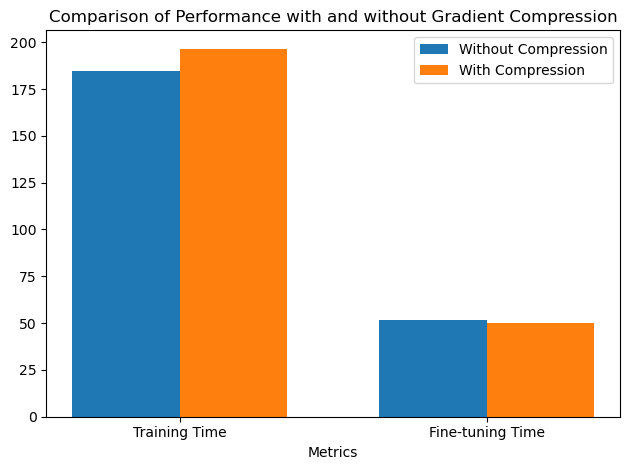

In [8]:
# Plotting results
def plot_results(results_without_compression, results_with_compression):
    """_summary_

    Args:
        results_without_compression (_type_): _description_
        results_with_compression (_type_): _description_
    """
    labels = ['Training Time', 'Fine-tuning Time']
    without_compression = [
     
        results_without_compression['training_time'],
        results_without_compression['fine_tuning_time'],
        
    ]
    with_compression = [
       
        results_with_compression['training_time'],
        results_with_compression['fine_tuning_time'],
       
    ]
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width/2, without_compression, width, label='Without Compression')
    bars2 = ax.bar(x + width/2, with_compression, width, label='With Compression')
    
    ax.set_xlabel('Metrics')
    ax.set_title('Comparison of Performance with and without Gradient Compression')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    fig.tight_layout()
    plt.show()

# Plot results
plot_results(results_without_compression, results_with_compression)